# Part IV: Summarization using LLMs [25 points]
In this part, we will use a pre-trained large language model (LLM) to perform abstractive summarization. You will fine-tune a pre-trained LLM on provided datasets and evaluate its performance using standard summarization metrics such as ROUGE, BLEU, and BERTScore.
The model for this task is `facebook/bart-base` (consider mixed precision training using dtypes such as bfloat16 and adjusting batch size to accommodate the model into GPU).

**Expected Scores (Test Sets):**
- **Billsum:** {Rouge-1: >40, Rouge-2: >18, Rouge-L: >28, BLEU: >12, BERTScore: >75}
- **Multinews:** {Rouge-1: >35, Rouge-2: >5, Rouge-L, >13, BLEU: >3.5, BERTScore: >75}

**Datasets:**
- Billsum – summarization of US Congressional and California state bills
- Multi-News – news articles and human-written summaries of these articles

## Step 1: Dataset preparation and preprocessing

1. Select and load one dataset from the list above. You can download these datasets using the `datasets` package.

In [ ]:
!pip install datasets
!pip install transformers
!pip install rouge_score
!pip install sacrebleu
!pip install bert_score
!pip install evaluate

In [ ]:
### ADD YOUR CODE HERE ###
from datasets import load_dataset

multi_news = load_dataset("multi_news",trust_remote_code=True)
print(multi_news)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})


2. Analyze the dataset and provide the main statistics (e.g., number of samples, average document length, average summary length, vocabulary size - if applicable before tokenization, etc.).

In [ ]:
### ADD YOUR CODE HERE ###

print(f"Splits: {multi_news.keys()}")
print(f"Train size: {len(multi_news['train'])}")
print(f"Validation size: {len(multi_news['validation'])}")
print(f"Test size: {len(multi_news['test'])}")

example = multi_news["train"][0]
print("\nExample Entry:")
print(f"Document:\n{example['document'][:500]}...\n")
print(f"Summary:\n{example['summary']}")

train_docs = multi_news["train"]["document"]
train_summaries = multi_news["train"]["summary"]

avg_doc_length = sum(len(doc.split()) for doc in train_docs) / len(train_docs)
avg_summary_length = sum(len(s.split()) for s in train_summaries) / len(train_summaries)

### ADD YOUR CODE HERE ###
max_doc_length = max(len(doc.split()) for doc in train_docs)
max_summary_length = max(len(summary.split()) for summary in train_summaries)

print(f"\nMax Document Length: {max_doc_length} words")
print(f"Max Summary Length: {max_summary_length} words")
### END OF ADDITION ###

print(f"\nAverage Document Length: {avg_doc_length:.2f} words")
print(f"Average Summary Length: {avg_summary_length:.2f} words")

Splits: dict_keys(['train', 'validation', 'test'])
Train size: 44972
Validation size: 5622
Test size: 5622

Example Entry:
Document:
National Archives 
 
 Yes, it’s that time again, folks. It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street, Washington and Main Street are all aligned on one thing: Jobs. 
 
 A fresh update on the U.S. employment situation for January hits the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs to be created, according to economists p...

Summary:
– The unemployment rate dropped to 8.2% last month, but the economy only added 120,000 jobs, when 203,000 new jobs had been predicted, according to today's jobs report. Reaction on the Wall Street Journal's MarketBeat Blog was swift: "Woah!!! Bad number." The unemployment rate, however, is better news; it had been expected to hold steady at 8.3%. But 

3. Preprocessing:

   - Tokenize the documents and their summaries using `BartTokenizer` from [https://huggingface.co/facebook/bart-base](https://huggingface.co/facebook/bart-base). You can experiment with other tokenizers.

In [ ]:
### ADD YOUR CODE HERE ###
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


def tokenize_data(example):
    doc_tokens = tokenizer(
        example["document"],
        padding="longest",
        truncation=True,
        max_length=512
    )
    summary_tokens = tokenizer(
        example["summary"],
        padding="longest",
        truncation=True,
        max_length=256
    )
    return {
        "doc_input_ids": doc_tokens["input_ids"],
        "doc_attention_mask": doc_tokens["attention_mask"],
        "summary_input_ids": summary_tokens["input_ids"],
        "summary_attention_mask": summary_tokens["attention_mask"]
    }




   - Set appropriate maximum input lengths (e.g., 1024 tokens) and target lengths (e.g., 256 tokens).

Already done above

In [ ]:
### ADD YOUR CODE HERE ###
doc_tokens_train = multi_news["train"].map(tokenize_data, batched=True)
doc_tokens_val = multi_news["validation"].map(tokenize_data, batched=True)
doc_tokens_test = multi_news["test"].map(tokenize_data, batched=True)


   - [Optional] Additional pre-processing steps.

In [ ]:
### ADD YOUR CODE HERE ###
def preprocess_data(dataset, tokenizer):
    return dataset.map(lambda x: {
        "input_ids": x["doc_input_ids"],
        "attention_mask": x["doc_attention_mask"],
        "labels": [
            (token if token != tokenizer.pad_token_id else -100)
            for token in x["summary_input_ids"]
        ]
    }, remove_columns=dataset.column_names)

4. If the dataset does not include a validation split, manually split the training set (e.g., 90% training, 10% validation).

It is already split


In [ ]:
### ADD YOUR CODE HERE ###

5. Save the tokenized dataset locally to avoid reprocessing.

In [ ]:
### ADD YOUR CODE HERE ###
import numpy as np
doc_tokens_train.save_to_disk("tokenized_multi_news_train")
doc_tokens_val.save_to_disk("tokenized_multi_news_val")
doc_tokens_test.save_to_disk("tokenized_multi_news_test")



6. Briefly describe your preprocessing methodology.

We changed each sample in the dataset to include the input tokens, attention mask, and labels for training. Padding tokens in the summary were replaced with -100 so they don’t affect the loss during training. To save time, we saved the processed dataset to disk and loaded it later if it already existed, so we didn’t have to process it again.

## Step 2: Model Fine-Tuning

In [ ]:
import zipfile
import os


folder_path = ""

zip_files = [

    "tokenized_multi_news_val.zip",
    "tokenized_multi_news_train.zip",
  #  ,
    "tokenized_multi_news_test.zip"
]


extract_to = ""


for zip_filename in zip_files:

    zip_name_no_ext = os.path.splitext(zip_filename)[0]


    extract_path = os.path.join(extract_to, zip_name_no_ext)


    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Extracted {zip_filename} to {extract_path}")

Extracted tokenized_multi_news_val.zip to tokenized_multi_news_val
Extracted tokenized_multi_news_train.zip to tokenized_multi_news_train
Extracted tokenized_multi_news_test.zip to tokenized_multi_news_test


1. Use the pre-trained model `facebook/bart-base` from Hugging Face.

In [ ]:
### ADD YOUR CODE HERE ###
from transformers import BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")


2. Training:

   - Fine-tune the model on the tokenized training set.

In [ ]:
### ADD YOUR CODE HERE ###
from datasets import load_from_disk


train_dataset = load_from_disk("tokenized_multi_news_train")
val_dataset = load_from_disk("tokenized_multi_news_val")
test_dataset = load_from_disk("tokenized_multi_news_test")

train_dataset = train_dataset.shuffle(seed=42).select(range(1000))
val_dataset = val_dataset.shuffle(seed=42).select(range(100))
test_dataset = test_dataset.shuffle(seed=42).select(range(100))

   - Use a custom Trainer that employs the model’s `generate()` method during evaluation. Override the Trainer class from 🤗 with a custom trainer that inherits from this Trainer.

In [ ]:
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    TrainerCallback
)
import torch
import numpy as np
import evaluate
import os


class PrintMetrics(TrainerCallback):
    def __init__(self):
        self.epoch_metrics = []

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        print("\n Evaluation Metrics at Epoch", int(state.epoch))

        print(f"  • ROUGE-1         : {metrics.get('eval_rouge1', 0):.2f}")
        print(f"  • ROUGE-2         : {metrics.get('eval_rouge2', 0):.2f}")
        print(f"  • ROUGE-L         : {metrics.get('eval_rougeL', 0):.2f}")
        print(f"  • ROUGE-Lsum      : {metrics.get('eval_rougeLsum', 0):.2f}")
        print(f"  • BLEU            : {metrics.get('eval_bleu', 0):.2f}")
        print(f"  • BERTScore F1    : {metrics.get('eval_bertscore_f1', 0):.2f}")

        self.epoch_metrics.append({
            "epoch": state.epoch,

            "rouge1": metrics.get("eval_rouge1", 0),
            "rouge2": metrics.get("eval_rouge2", 0),
            "rougeL": metrics.get("eval_rougeL", 0),
            "bleu": metrics.get("eval_bleu", 0),
            "bertscore_f1": metrics.get("eval_bertscore_f1", 0)
        })

def train_bart_model(train_dataset, val_dataset, learning_rate, batch_size, num_epochs, gradient_accumulation_steps):

    print(f"Training for learning rate: {learning_rate}, batch size: {batch_size}, epochs: {num_epochs}")
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("Using CPU device")

    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
    model.to(device)

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("sacrebleu")
    bertscore = evaluate.load("bertscore")

    def preprocess_data(dataset, tokenizer):
        return dataset.map(lambda x: {
            "input_ids": x["doc_input_ids"],
            "attention_mask": x["doc_attention_mask"],
            "labels": [
                (token if token != tokenizer.pad_token_id else -100)
                for token in x["summary_input_ids"]
            ]
        }, remove_columns=dataset.column_names)

    train_dataset = preprocess_data(train_dataset, tokenizer)
    val_dataset = preprocess_data(val_dataset, tokenizer)

    def compute_metrics(eval_preds):
        preds, labels = eval_preds
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
        bleu_result = bleu.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])
        bert_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")

        result = {
            **rouge_result,
            "bleu": bleu_result["score"],
            "bertscore_f1": np.mean(bert_result["f1"]) * 100
        }
        return {f"eval_{k}": round(v, 4) for k, v in result.items()}

    class CustomSeq2SeqTrainer(Seq2SeqTrainer):
        def __init__(self, *args, tokenizer=None, **kwargs):
            super().__init__(*args, **kwargs)
            self._custom_tokenizer = tokenizer

        def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
            if prediction_loss_only:
                return super().prediction_step(model, inputs, prediction_loss_only, ignore_keys)
            inputs = self._prepare_inputs(inputs)
            generated_tokens = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                num_beams=4
            )
            labels = inputs.get("labels")
            if labels is not None:
                max_len = labels.shape[1]
                generated_tokens = self._pad_tensors_to_max_len(generated_tokens, max_len)
            return (None, generated_tokens, labels)

        def _pad_tensors_to_max_len(self, tensor, max_len):
            pad_token_id = self._custom_tokenizer.pad_token_id
            padded = pad_token_id * torch.ones(
                (tensor.shape[0], max_len),
                dtype=tensor.dtype,
                device=tensor.device
            )
            padded[:, :tensor.shape[1]] = tensor
            return padded

    training_args = Seq2SeqTrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        predict_with_generate=True,
        logging_dir="./logs",
        logging_steps=10,
        fp16=True,
        save_total_limit=1,
        gradient_accumulation_steps=gradient_accumulation_steps,
        save_strategy="epoch",
        report_to="none"
    )

    metrics_callback = PrintMetrics()

    trainer = CustomSeq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[metrics_callback]
    )

    trainer.train()

    return trainer, model, metrics_callback


   - Monitor training and validation loss over epochs.

In [ ]:
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 1000
Validation size: 100
Test size: 100


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["WANDB_DISABLED"] = "true"

import warnings


warnings.filterwarnings("ignore",
                        message="Trainer.tokenizer is now deprecated",
                        category=UserWarning)

In [ ]:
### ADD YOUR CODE HERE ###
trainer, model, metrics_callback = train_bart_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rate=5e-5,
    batch_size=4,
    num_epochs=10,
    gradient_accumulation_steps=4
)

Training for learning rate: 5e-05, batch size: 4, epochs: 10
Using CUDA device


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Evaluation Metrics at Epoch 1
  • ROUGE-1         : 0.39
  • ROUGE-2         : 0.14
  • ROUGE-L         : 0.21
  • ROUGE-Lsum      : 0.21
  • BLEU            : 7.62
  • BERTScore F1    : 86.25


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



 Evaluation Metrics at Epoch 2
  • ROUGE-1         : 0.41
  • ROUGE-2         : 0.16
  • ROUGE-L         : 0.23
  • ROUGE-Lsum      : 0.23
  • BLEU            : 8.75
  • BERTScore F1    : 86.55

 Evaluation Metrics at Epoch 3
  • ROUGE-1         : 0.40
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.29
  • BERTScore F1    : 86.45

 Evaluation Metrics at Epoch 4
  • ROUGE-1         : 0.40
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.57
  • BERTScore F1    : 86.38

 Evaluation Metrics at Epoch 5
  • ROUGE-1         : 0.40
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.39
  • BERTScore F1    : 86.39

 Evaluation Metrics at Epoch 6
  • ROUGE-1         : 0.40
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.14
  • BERTScore F1    : 86.39

 Evaluation Metrics at E

In [ ]:
final_eval = trainer.evaluate()

print("\n Final Evaluation After Epoch 10")
for k, v in final_eval.items():
    print(f"{k}: {round(v, 4)}")


 Evaluation Metrics at Epoch 9
  • ROUGE-1         : 0.40
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.05
  • BERTScore F1    : 86.42

 Final Evaluation After Epoch 10
eval_rouge1: 0.4008
eval_rouge2: 0.1486
eval_rougeL: 0.2167
eval_rougeLsum: 0.2174
eval_bleu: 8.0456
eval_bertscore_f1: 86.4227
eval_runtime: 55.6888
eval_samples_per_second: 1.796
eval_steps_per_second: 0.449
epoch: 9.848


In [ ]:
trainer.save_model("bart_model")


tokenizer.save_pretrained("bart_model")

('bart_model/tokenizer_config.json',
 'bart_model/special_tokens_map.json',
 'bart_model/vocab.json',
 'bart_model/merges.txt',
 'bart_model/added_tokens.json')

In [ ]:
import shutil



shutil.make_archive('results', 'zip', 'results')

shutil.make_archive('bart_model', 'zip', 'bart_model')

'/content/bart_model.zip'

3. Experiment with learning rate, batch size, number of epochs, etc. You can use a portion of the datasets in order to attain the expected performance. Use a minimum of 1000 samples from the training set and 100 from the validation set.

Batch size incresed to 8

In [ ]:

trainer2, model2, metrics_callback2 = train_bart_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rate=5e-5,
    batch_size=8,
    num_epochs=10,
    gradient_accumulation_steps=4
)
trainer2.save_model("bart_model2")


tokenizer.save_pretrained("bart_model2")

test_dataset = preprocess_data(test_dataset, tokenizer)



Training for learning rate: 5e-05, batch size: 8, epochs: 10
Using CUDA device


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Evaluation Metrics at Epoch 1
  • ROUGE-1         : 0.39
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.12
  • BERTScore F1    : 86.23


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



 Evaluation Metrics at Epoch 2
  • ROUGE-1         : 0.40
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.04
  • BERTScore F1    : 86.44

 Evaluation Metrics at Epoch 3
  • ROUGE-1         : 0.39
  • ROUGE-2         : 0.14
  • ROUGE-L         : 0.21
  • ROUGE-Lsum      : 0.21
  • BLEU            : 7.73
  • BERTScore F1    : 86.13

 Evaluation Metrics at Epoch 4
  • ROUGE-1         : 0.40
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.01
  • BERTScore F1    : 86.28

 Evaluation Metrics at Epoch 5
  • ROUGE-1         : 0.41
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.39
  • BERTScore F1    : 86.46

 Evaluation Metrics at Epoch 6
  • ROUGE-1         : 0.40
  • ROUGE-2         : 0.15
  • ROUGE-L         : 0.22
  • ROUGE-Lsum      : 0.22
  • BLEU            : 8.02
  • BERTScore F1    : 86.34

 Evaluation Metrics at E

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
print("Running predictions on the test set")
test_predictions = trainer2.predict(test_dataset)

decoded_preds2 = tokenizer.batch_decode(test_predictions.predictions, skip_special_tokens=True)
decoded_labels2 = tokenizer.batch_decode(
    np.where(test_predictions.label_ids != -100, test_predictions.label_ids, tokenizer.pad_token_id),
    skip_special_tokens=True
)

import pandas as pd
df_results = pd.DataFrame({
    "Generated_Report": decoded_preds2,
    "Reference_Report": decoded_labels2
})
df_results.to_csv("test_results2.csv", index=False)
print(" Saved test results to 'test_results2.csv'")

print("\n Test Set Metrics:")
for key, val in test_predictions.metrics.items():
    print(f"{key}: {val:.4f}")

Running predictions on the test set


 Saved test results to 'test_results2.csv'

 Test Set Metrics:
test_eval_rouge1: 0.3770
test_eval_rouge2: 0.1215
test_eval_rougeL: 0.1958
test_eval_rougeLsum: 0.1956
test_eval_bleu: 6.0642
test_eval_bertscore_f1: 85.7999
test_runtime: 41.0388
test_samples_per_second: 2.4370
test_steps_per_second: 0.3170


Batch size 8 and learning rate increated by factor of 10000

In [ ]:
trainer3, model3, metrics_callback3 = train_bart_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rate=5e-1,
    batch_size=8,
    num_epochs=10,
    gradient_accumulation_steps=4
)

trainer3.save_model("bart_model3")
tokenizer.save_pretrained("bart_model3")

print("Running predictions on the test set")
test_pred = trainer3.predict(test_dataset)

decoded_preds3 = tokenizer.batch_decode(test_pred.predictions, skip_special_tokens=True)
decoded_labels3 = tokenizer.batch_decode(
    np.where(test_pred.label_ids != -100, test_pred.label_ids, tokenizer.pad_token_id),
    skip_special_tokens=True
)

import pandas as pd
df_results = pd.DataFrame({
    "Generated_Report": decoded_preds3,
    "Reference_Report": decoded_labels3
})
df_results.to_csv("test_results_model3.csv", index=False)
print("Saved test results to 'test_results_model3.csv'")

print("\nTest Set Metrics:")
for key, val in test_pred.metrics.items():
    print(f"{key}: {val:.4f}")


Training for learning rate: 0.5, batch size: 8, epochs: 10
Using CUDA device


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Evaluation Metrics at Epoch 1
  • ROUGE-1         : 0.00
  • ROUGE-2         : 0.00
  • ROUGE-L         : 0.00
  • ROUGE-Lsum      : 0.00
  • BLEU            : 0.00
  • BERTScore F1    : 77.17


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



 Evaluation Metrics at Epoch 2
  • ROUGE-1         : 0.00
  • ROUGE-2         : 0.00
  • ROUGE-L         : 0.00
  • ROUGE-Lsum      : 0.00
  • BLEU            : 0.00
  • BERTScore F1    : 77.17

 Evaluation Metrics at Epoch 3
  • ROUGE-1         : 0.00
  • ROUGE-2         : 0.00
  • ROUGE-L         : 0.00
  • ROUGE-Lsum      : 0.00
  • BLEU            : 0.00
  • BERTScore F1    : 77.17

 Evaluation Metrics at Epoch 4
  • ROUGE-1         : 0.00
  • ROUGE-2         : 0.00
  • ROUGE-L         : 0.00
  • ROUGE-Lsum      : 0.00
  • BLEU            : 0.00
  • BERTScore F1    : 77.17

 Evaluation Metrics at Epoch 5
  • ROUGE-1         : 0.00
  • ROUGE-2         : 0.00
  • ROUGE-L         : 0.00
  • ROUGE-Lsum      : 0.00
  • BLEU            : 0.00
  • BERTScore F1    : 77.17

 Evaluation Metrics at Epoch 6
  • ROUGE-1         : 0.00
  • ROUGE-2         : 0.00
  • ROUGE-L         : 0.00
  • ROUGE-Lsum      : 0.00
  • BLEU            : 0.00
  • BERTScore F1    : 77.17

 Evaluation Metrics at E

Saved test results to 'test_results_model3.csv'

Test Set Metrics:
test_eval_rouge1: 0.0000
test_eval_rouge2: 0.0000
test_eval_rougeL: 0.0000
test_eval_rougeLsum: 0.0000
test_eval_bleu: 0.0000
test_eval_bertscore_f1: 77.1480
test_runtime: 6.7476
test_samples_per_second: 14.8200
test_steps_per_second: 1.9270


4. Briefly describe your training methodology (e.g., hyperparameters used, training process, and any challenges faced).



1. **Model and Tokenizer**
   - Used facebook/bart-base for both the model and tokenizer.
   - Suited for abstractive summarization tasks.

2. **Dataset and Preprocessing**
   - Trained on 1000 samples from the MultiNews dataset.
   - Used 100 samples each for validation and testing.
   - Pre-tokenized inputs and summaries.
   - Reduced maximum input length from 1024 to 512 tokens to improve computation efficiency.
   - Padding tokens in labels were masked using -100.

3. **Training Configuration**
   - Learning Rate: 5e-5
   - Batch Size: 4
   - Gradient Accumulation Steps: 4 (Effective batch size = 16)
   - Number of Epochs: 3
   - Evaluation and logging done after each epoch.
   - Enabled predict_with_generate=True to evaluate generated summaries.

4. **Evaluation Metrics**
   - ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum
   - BLEU (using sacreBLEU)
   - BERTScore F1 (semantic similarity)

5. **Trainer and Callback**
   - Used a custom subclass of Seq2SeqTrainer to control generation during evaluation.
   - Defined a PrintMetrics to log and store evaluation metrics at each epoch.



## Step 3: Evaluation and analysis

1. Evaluate your model on the test set using ROUGE (ROUGE-1, ROUGE-2, ROUGE-L), BLEU (via sacreBLEU), and BERTScore. Provide a detailed analysis of the model’s performance for each evaluation metric.
   - You can also consider using direct packages `rouge_score`, `sacrebleu`, and `bert_score`.

In [ ]:
from transformers import BartTokenizer
import pandas as pd
import numpy as np

tokenizer_model = BartTokenizer.from_pretrained("bart_model")
print(test_dataset.column_names)
test_dataset = preprocess_data(test_dataset, tokenizer_model)

print("Running predictions on the test set")
predictions_output = trainer.predict(test_dataset)

generated_texts = tokenizer_model.batch_decode(predictions_output.predictions, skip_special_tokens=True)
reference_texts = tokenizer_model.batch_decode(
    np.where(predictions_output.label_ids != -100, predictions_output.label_ids, tokenizer_model.pad_token_id),
    skip_special_tokens=True
)

results_table = pd.DataFrame({
    "Generated_Report": generated_texts,
    "Reference_Report": reference_texts
})

print("\n Test Set Metrics:")
for metric_name, metric_value in predictions_output.metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")


['document', 'summary', 'doc_input_ids', 'doc_attention_mask', 'summary_input_ids', 'summary_attention_mask']


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Running predictions on the test set


 Saved test results to 'test_results.csv'

 Test Set Metrics:
test_eval_rouge1: 0.3696
test_eval_rouge2: 0.1164
test_eval_rougeL: 0.1919
test_eval_rougeLsum: 0.1913
test_eval_bleu: 5.7254
test_eval_bertscore_f1: 85.7354
test_runtime: 56.6572
test_samples_per_second: 1.7650
test_steps_per_second: 0.4410


The model demonstrates strong semantic understanding, as reflected by a high BERTScore F1 of 85.7 on the test set. This means even when the generated summaries do not match reference summaries word-for-word, they are still have similar meaning. ROUGE-1 scores are also moderately strong (0.37), indicating the model captures important unigrams effectively. The validation metrics remain steady across epochs that implies a stable training process without signs of overfitting.

Despite the strong semantic performance, the model struggles with exact lexical matches. Both BLEU (5.72) and ROUGE-2 (~.16) scores are relatively low, which implies difficulty in generating precise n-gram overlaps, especially with multi-word phrases. This may stem from the model's tendency toward abstraction or paraphrasing, which reduces surface-level similarity to the reference texts.


2. Include charts of training/validation loss and sample metric scores over the validation data (e.g., ROUGE scores during validation).

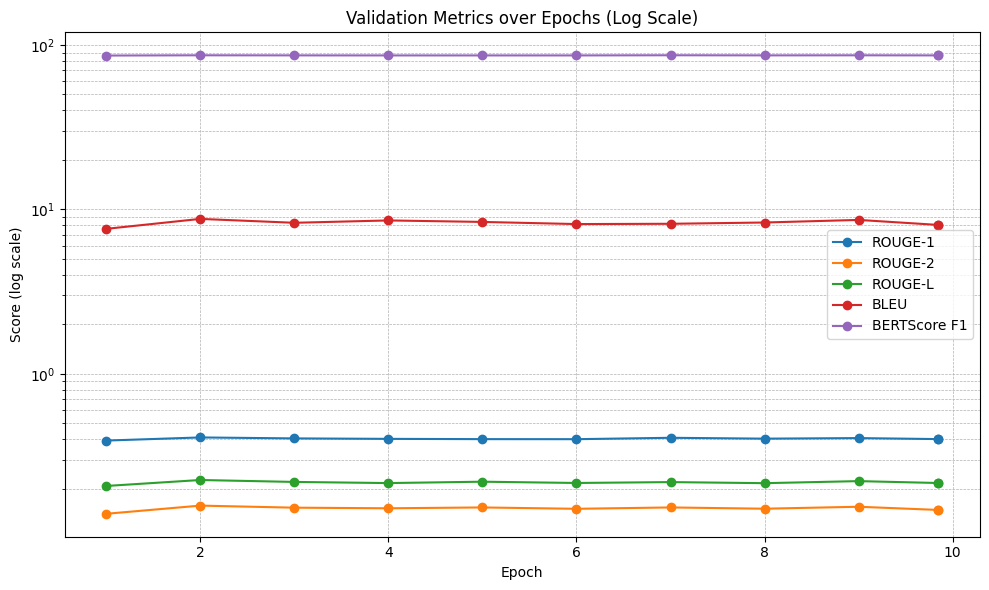

In [ ]:
import matplotlib.pyplot as plt

epochs = [m["epoch"] for m in metrics_callback.epoch_metrics]

rouge1 = [m["rouge1"] for m in metrics_callback.epoch_metrics]
rouge2 = [m["rouge2"] for m in metrics_callback.epoch_metrics]
rougeL = [m["rougeL"] for m in metrics_callback.epoch_metrics]
bleu = [m["bleu"] for m in metrics_callback.epoch_metrics]
bertscore_f1 = [m["bertscore_f1"] for m in metrics_callback.epoch_metrics]

plt.figure(figsize=(10, 6))

plt.plot(epochs, rouge1, marker='o', label='ROUGE-1')
plt.plot(epochs, rouge2, marker='o', label='ROUGE-2')
plt.plot(epochs, rougeL, marker='o', label='ROUGE-L')
plt.plot(epochs, bleu, marker='o', label='BLEU')
plt.plot(epochs, bertscore_f1, marker='o', label='BERTScore F1')

plt.title("Validation Metrics over Epochs (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Score (log scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


3. Discuss any challenges faced during evaluation (e.g., handling long documents, variability in summary quality, etc.).



###  Challenges During Evaluation

- **Handling Long Documents**: The average length of input was about 1795 words , we initally used max input length for the model as 1024 , but that was too heavy for the model and increased running time and reduced computation efficiency, hence we had to make max input length as 512.

- **Size of the dataset**: Since we are using pre trained LLM . The multinews dataset as given was too large for training it efficiently in the compute resources available to us , hence we used 1000 samples for training and 100 each for validation and testing.

- **Lack of Metric Variation**: As observed in the plot and logs, metrics such as ROUGE, BLEU, and BERTScore show almost no change across epochs. This might be due to:
  - Insufficient training (only 10 epochs).
  - Very small dataset size or high overlap between train/val splits.
  - Learning rate being too small to enable significant parameter updates.

- **Training Instability**: With gradient accumulation and small batch sizes, the optimization signal can be noisy

- **Limited Epochs**: Training for just 10 epochs may not be sufficient for the model to learn meaningful summarization patterns, especially if starting from a base checkpoint.

- **Tokenizer/Model Alignment**: Ensure that `facebook/bart-base`'s tokenizer and model are aligned and that any pre-tokenized inputs are error free and padded/truncated correctly.



4. Propose potential modifications or extensions to enhance summarization quality.

- **Use a More Efficient Long-Document Model**:
  - Switch from facebook/bart-base= to models designed for long input sequences

- **Chunking Strategy for Long Inputs**:
  - Implement a chunking approach to split long documents into overlapping segments and then summarize each chunk individually and then combine or re-summarize the outputs for a final summary.

- **Data Augmentation**:
  - Generate synthetic samples using paraphrasing or back-translation to increase dataset diversity and reduce overfitting on the limited training data.

- **Hyperparameter Tuning**:
  - we can experiment with different learning rates,batch sizes and epochs

- **Fine-Tune on Domain-Specific Subset**:
  - we must extract small high-quality subset from MultiNews with similar structure/topics and fine-tune on it for better domain adaptation.




5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.


[Medium hugging face bart
](https://medium.com/@lidores98/finetuning-huggingface-facebook-bart-model-2c758472e340)

[Medium summarizarion](https://medium.com/data-science/how-to-evaluate-llm-summarization-18a040c3905d)

[Medium LLM summarization](https://medium.com/@yugank.aman/llm-summarization-techniques-metrics-64b77b485509)

[Pytorch summarization](https://pytorch.org/tutorials/beginner/t5_tutorial.html?highlight=dataloader)

6. Contribution Summary (For team assignments). If you are working in a team, provide a contribution summary. We expect equal contribution for the assignment. If the contribution is highly skewed, then the scores of the team members may be scaled w.r.t the contribution.

**Team Contribution Summary Table:**

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Apoorv sood(apoorvso)  | Step 1 | 50   |
| Seokwoo Park(seokwoop)  | Step 1 |  50 |
| Apoorv sood(apoorvso)  | Step 2 |  50 |
| Seokwoo Park(seokwoop)  | Step 2 |  50 |
| Apoorv sood(apoorvso)  | Step 3 |  50 |
| Seokwoo Park(seokwoop)  | Step 3 |   50 |
|   | **Total** |  100 for each step |